## **Import Liberaries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file

In [ ]:
# Image and file operations
import cv2  # OpenCV: Used for image processing and computer vision tasks
import os  # OS module: Used for interacting with the operating system (e.g., directory handling)
import shutil  # Shutil: Used for file operations like copying and moving files

# Utility
import itertools  # Provides functions for efficient looping and combinatorics

# Visualization
import matplotlib.pyplot as plt  # Matplotlib: Used for creating static, animated, and interactive visualizations
import seaborn as sns  # Seaborn: Built on matplotlib, used for statistical data visualization

# Data preprocessing and evaluation
from sklearn.preprocessing import OneHotEncoder  # Used to convert categorical labels into one-hot encoded vectors
from sklearn.model_selection import train_test_split  # Used to split data into training and testing sets
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Used for evaluating model performance

# Image preprocessing and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation

# Pretrained CNN model and preprocessing
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  # VGG16 model and its input preprocessing

# Building neural networks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
# These layers are the building blocks for creating custom CNN models

# Model training utilities
from tensorflow.keras.callbacks import EarlyStopping  # Stops training when a monitored metric has stopped improving

# Model architecture
from tensorflow.keras.models import Sequential  # Linear stack of layers
from tensorflow.keras.models import Model  # Base class for defining complex models

# Optimization algorithms
from tensorflow.keras.optimizers import Adam, Adamax  # Optimizers used to minimize loss during training

# Regularization
from tensorflow.keras import regularizers  # Provides various regularization methods
from tensorflow.keras.regularizers import l2  # L2 regularization (Ridge-like) to prevent overfitting

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')  # Ignores warnings in the notebook/script output

In [ ]:
from google.colab import drive

## **Import Dataset**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/breast cancer image dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
TRAIN_PATH = '/content/Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(TRAIN_PATH)
for fold in folds:
    fold_path = os.path.join(TRAIN_PATH,fold)
    filelists = os.listdir(fold_path)
    for file in filelists:
        filepaths.append(os.path.join(fold_path,file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
train_df = pd.concat([Fseries,Lseries], axis = 1)

In [ ]:
TEST_PATH = '/content/Dataset_BUSI_with_GT'
filepaths = []
labels = []

folds = os.listdir(TEST_PATH)
for fold in folds:
    fold_path = os.path.join(TEST_PATH,fold)
    filelists = os.listdir(fold_path)
    for file in filelists:
        filepaths.append(os.path.join(fold_path,file))
        labels.append(fold)

Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
test_df = pd.concat([Fseries,Lseries], axis = 1)

## **Data Analysis**

In [ ]:
train_df

,filepaths,labels
0,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
3,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
...,...,...
1573,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1574,/content/Dataset_BUSI_with_GT/benign/benign (9...,benign
1575,/content/Dataset_BUSI_with_GT/benign/benign (6...,benign
1576,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign


In [ ]:
test_df

,filepaths,labels
0,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
3,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
...,...,...
1573,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1574,/content/Dataset_BUSI_with_GT/benign/benign (9...,benign
1575,/content/Dataset_BUSI_with_GT/benign/benign (6...,benign
1576,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign


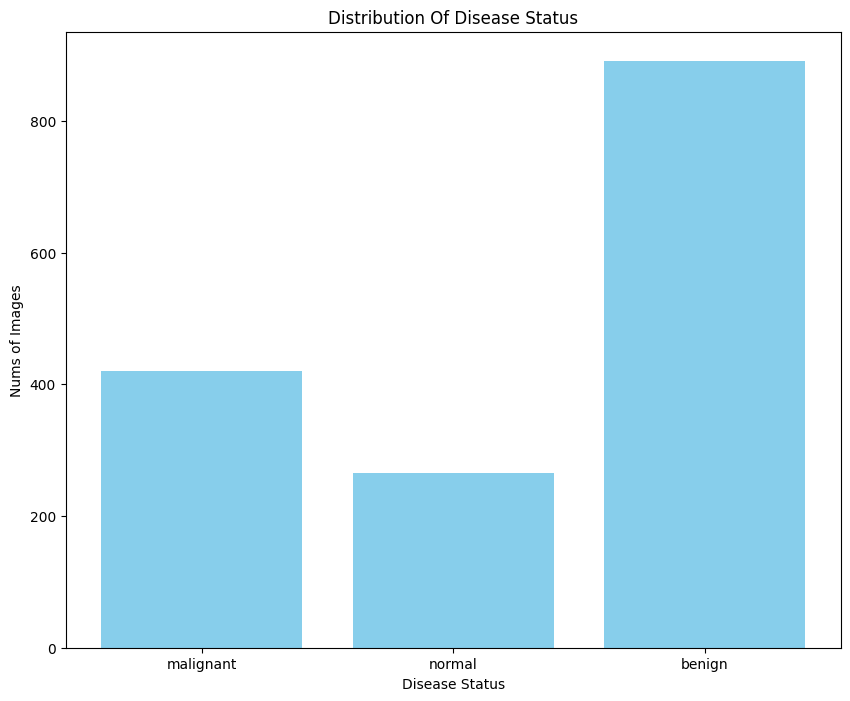

In [ ]:
status_names = os.listdir(TRAIN_PATH)
state_counts = {status_name : len(os.listdir(os.path.join(TRAIN_PATH,status_name))) for status_name in status_names}

plt.figure(figsize = (10,8))
plt.bar(state_counts.keys(),state_counts.values(),color = 'skyblue')
plt.xlabel('Disease Status')
plt.ylabel('Nums of Images')
plt.title('Distribution Of Disease Status')
plt.show()

## **Splitting and Preprocessing Images**

In [ ]:
valid,test = train_test_split(test_df,train_size = 0.5,shuffle=True,random_state = 45)

In [ ]:
img_size = (500,500)
batch_size = 16
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range= 0.1,
    brightness_range =[0.5,1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input # VGG 16
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)
test_gen = test_datagen.flow_from_dataframe(
    test,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False
)
valid_gen = test_datagen.flow_from_dataframe(
    valid,
    x_col = 'filepaths',
    y_col = 'labels',
    target_size = img_size,
    batch_size = batch_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True
)
print('Training State Indices :', train_gen.class_indices)
print('Test State Indices :', test_gen.class_indices)

Found 1578 validated image filenames belonging to 3 classes.
Found 789 validated image filenames belonging to 3 classes.
Found 789 validated image filenames belonging to 3 classes.
Training State Indices : {'benign': 0, 'malignant': 1, 'normal': 2}
Test State Indices : {'benign': 0, 'malignant': 1, 'normal': 2}


Display a Sample of Images With their Corresponding Disease Status

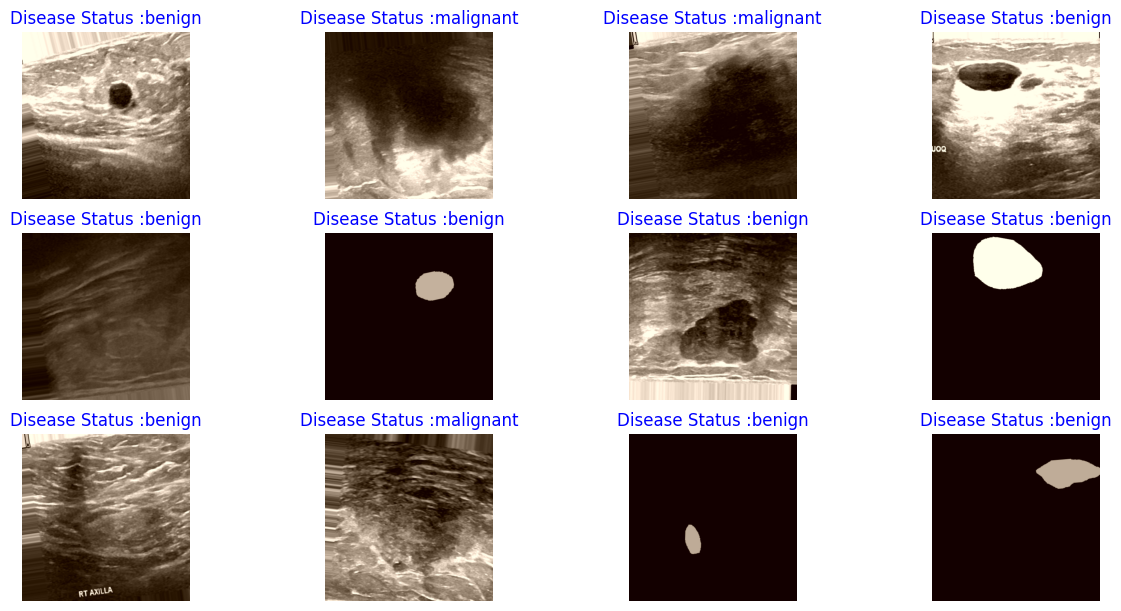

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(4,4,i + 1)
    # Return the image to its original form
    mean = [123.68, 116.779, 103.939] # VGG-16 Means
    img = images[i] + mean
    img = np.clip(img, 0, 255).astype('uint8') # Clip Values to [0,255]
    plt.imshow(img)
    plt.title(f'Disease Status :{classes[labels[i].argmax()]}',color = 'blue', fontsize = 12)
    plt.axis('off')
plt.show()

# VGG-16 Architecture
![](https://miro.medium.com/v2/resize:fit:1400/0*6VP81rFoLWp10FcG)

##**Model Training**

In [ ]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = img_shape,
                   pooling ='max'
                   )
# Freeze the base model
base_model.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(256, kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_class,activation ='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer = Adamax(learning_rate=0.0005),
             loss = 'categorical_crossentropy',
              metrics =['accuracy']
              )

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 500, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 500, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 250, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 250, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 125, 125, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 125, 125, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 62, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 62, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 62, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 31, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 31, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 31, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             

 Total params: 14,847,811 (56.64 MB)

 Trainable params: 132,611 (518.01 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [ ]:
Epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True,verbose = 1)
history = model.fit(
    train_gen,
    epochs = Epochs,
    verbose = 1,
    validation_data = valid_gen,
    validation_steps = None,
    shuffle = False,
    callbacks = [early_stopping]
)

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.4629 - loss: 4.6237 - val_accuracy: 0.7529 - val_loss: 3.8950
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6990 - loss: 3.7577 - val_accuracy: 0.7858 - val_loss: 3.5646
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7695 - loss: 3.4369 - val_accuracy: 0.7959 - val_loss: 3.4347
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7895 - loss: 3.2702 - val_accuracy: 0.8023 - val_loss: 3.1753
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7800 - loss: 3.1045 - val_accuracy: 0.8048 - val_loss: 3.0599
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7951 - loss: 2.9197 - val_accuracy: 0.8137 - val_loss: 2.8975
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7892 - loss: 2.8197 - val_accuracy: 0.8251 - val_loss: 2.7593
Epoch 8/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7766 - loss: 2.7095 - val_accuracy: 0.8112 - v

# Model Evaluation

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epochs = {str(index_loss + 1)}'
acc_label = f'Best Epochs = {str(index_acc + 1)}'

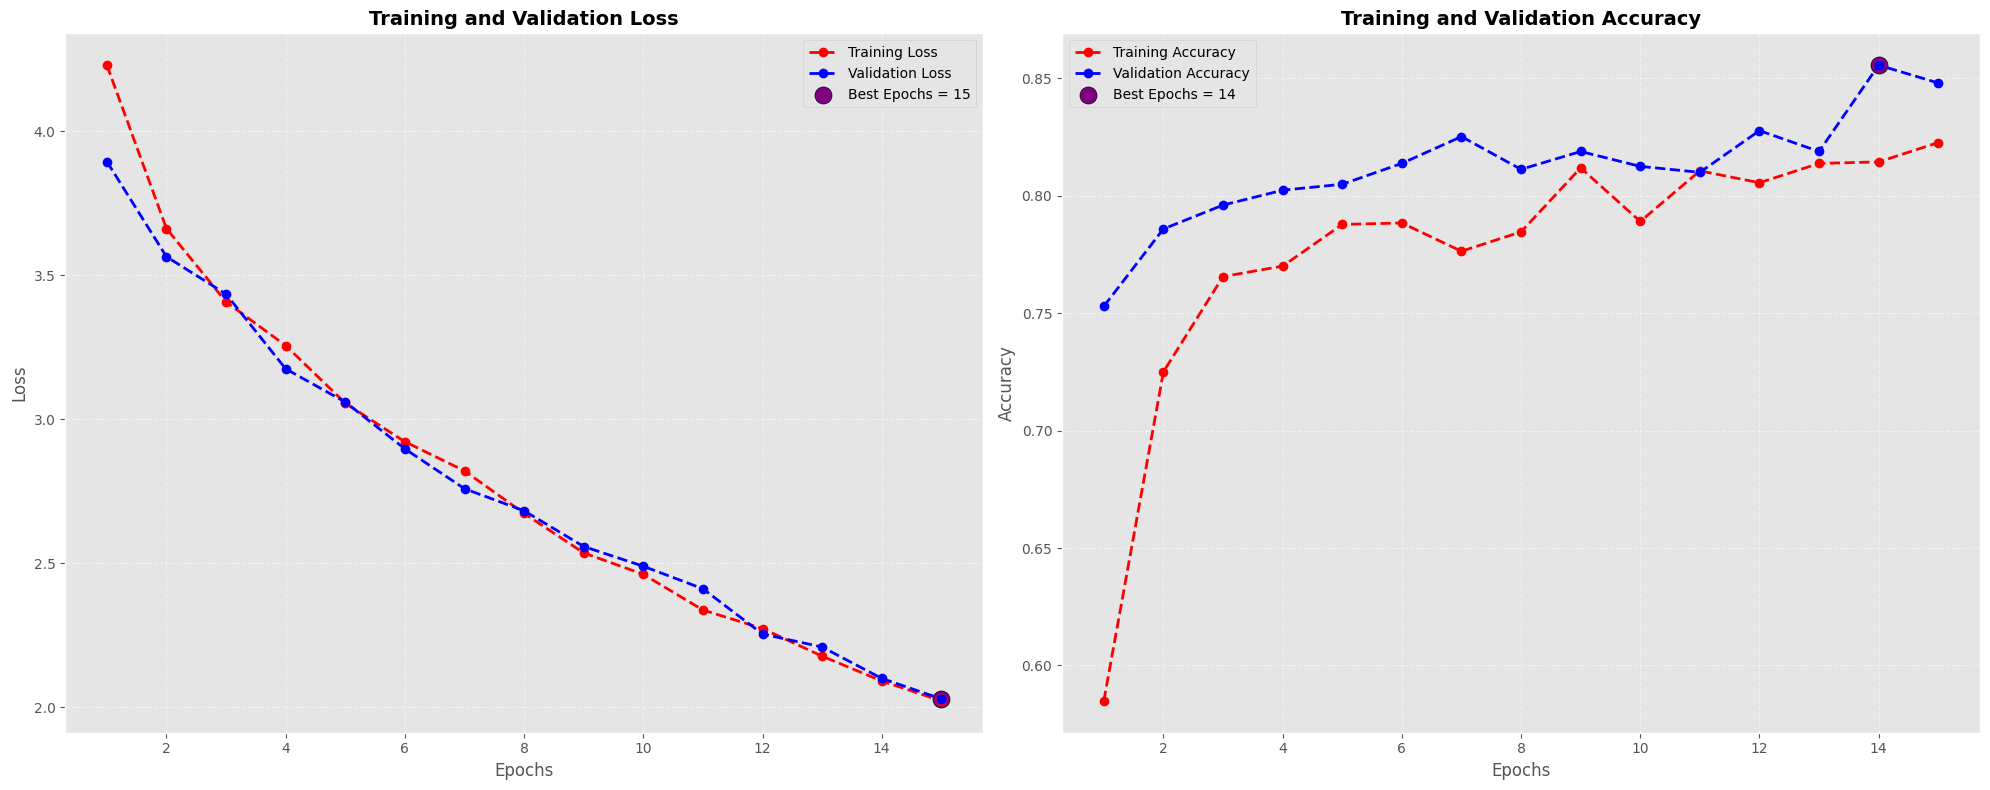

In [ ]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#acc plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
train_score = model.evaluate(train_gen, steps = 16, verbose = 1)
valid_score = model.evaluate(valid_gen, steps = 16, verbose = 1)
test_score = model.evaluate(test_gen, steps = 16, verbose = 1)
print("Train Loss: ",train_score[0])
print("Train Accuracy: ",train_score[1])
print('-' * 20)
print("Validation Loss: ",valid_score[0])
print("Validation Accuracy: ",valid_score[1])
print('-' * 20)
print('Test Loss: ',test_score[0])
print('Test Accuracy: ',test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8402 - loss: 1.9898
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.8419 - loss: 2.0114
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8229 - loss: 1.9272
Train Loss:  1.9062018394470215
Train Accuracy:  0.85546875
--------------------
Validation Loss:  2.0148818492889404
Validation Accuracy:  0.8359375
--------------------
Test Loss:  1.9534058570861816
Test Accuracy:  0.8359375


# Confusion Matrix

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step


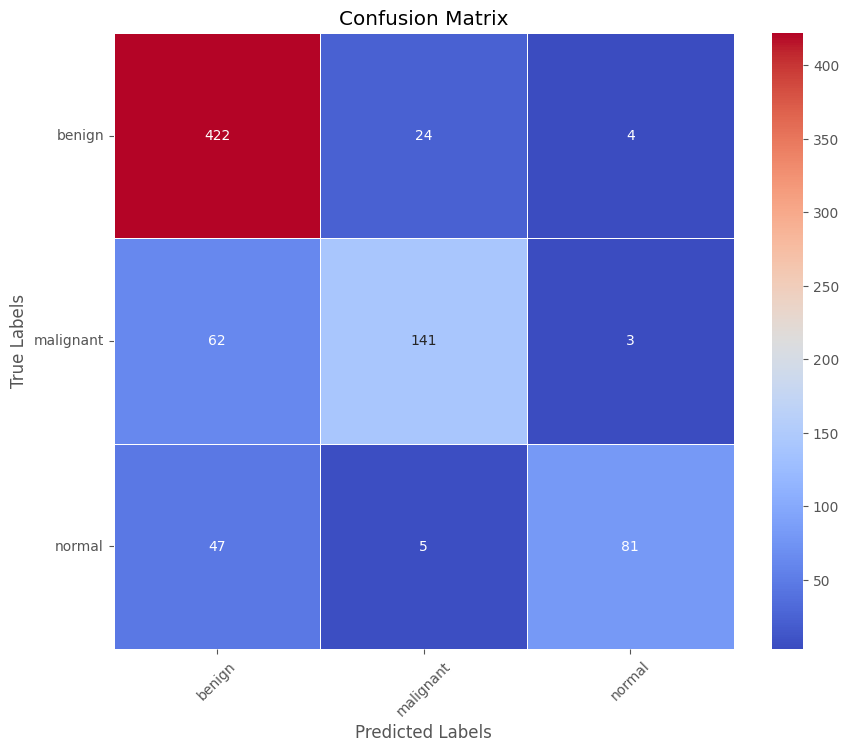

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds,axis = 1)
# Get Class Labels
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_gen.classes,y_pred)
plt.figure(figsize= (10,8))
sns.heatmap(cm,annot = True,fmt = 'd', cmap = 'coolwarm', xticklabels = classes, yticklabels = classes, linewidths = 0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show()